In [2]:
#1) Read in `transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

#2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

#$y = b$, for $t<t_0$

#$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

#where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

#Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

#3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

#4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

#5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

#6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

#7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.optimize import minimize
from numpy.random import default_rng 

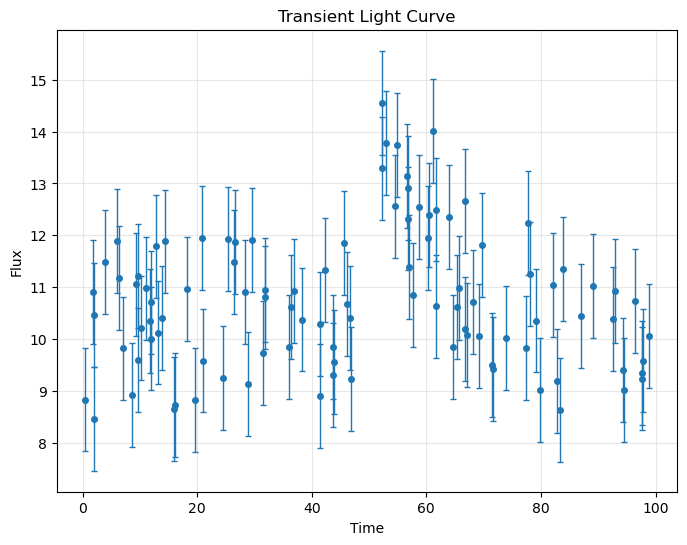

In [4]:

rng = default_rng(42)  # reproducibility

# Load and plot data
def load_data(filepath="transient.npy"):
    data = np.load(filepath)
    t, y, yerr = data.T
    return t, y, yerr 

def plot_data(t, y, yerr, ax=None, label="Observed data"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    ax.errorbar(t, y, yerr=yerr, fmt='o', ms=4, lw=1, capsize=2, label=label)
    ax.set_xlabel("Time")
    ax.set_ylabel("Flux")
    ax.set_title("Transient Light Curve")
    ax.grid(True, alpha=0.3)
    return ax

t, y, yerr = load_data()
plot_data(t, y, yerr)
plt.show()


In [5]:

#  Burst model and likelihood

def burst_model(theta, t):
    """
    Burst model:
    y = b                                   if t < t0
    y = b + A * exp[-alpha * (t - t0)]      if t >= t0
    theta = [b, A, t0, alpha]
    """
    b, A, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))

#Gaussian log-likelihood
def log_likelihood(theta, t, y, yerr):
    model = burst_model(theta, t)
    chi2 = np.sum(((y - model) / yerr) ** 2)
    return -0.5 * chi2


C:\Users\hp\AppData\Local\Temp\ipykernel_11692\564891746.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))



=== Maximum Likelihood Fit ===
theta_MLE [b, A, t0, alpha] = [10.30633562  8.78344681 46.86512363  0.13986814]


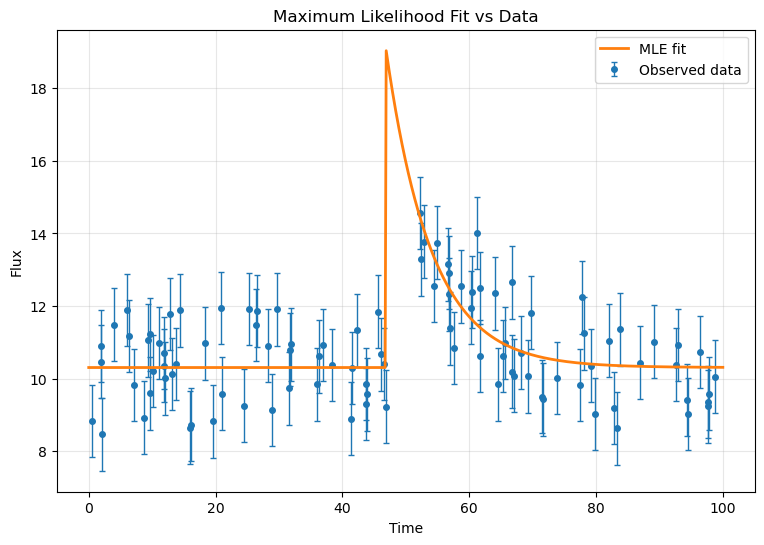

In [6]:
# Maximum Likelihood Fit (MLE) (Constrained within the same bounds as the priors)
def mle_fit(t, y, yerr, theta_start=(10.0, 10.0, 50.0, 0.1)):
    bounds = [(1e-9, 50.0),   # b
              (1e-9, 50.0),   # A
              (1e-9, 100.0),  # t0
              (np.exp(-5)+1e-12, np.exp(5))]  # alpha

    def neg_loglike(th):
        return -log_likelihood(th, t, y, yerr)

    res = minimize(neg_loglike, x0=np.array(theta_start), bounds=bounds, method="L-BFGS-B")
    return res.x, res

# MLE fit (just to see what happens)
theta_mle, res = mle_fit(t, y, yerr, theta_start=(10., 10., 50., 0.1))
print("\n=== Maximum Likelihood Fit ===")
print(f"theta_MLE [b, A, t0, alpha] = {theta_mle}")

# Show MLE vs data
t_fine = np.linspace(0, 100, 600)
fig, ax = plt.subplots(figsize=(9,6))
plot_data(t, y, yerr, ax=ax)
ax.plot(t_fine, burst_model(theta_mle, t_fine), lw=2, label="MLE fit", zorder=5)
ax.legend()
ax.set_title("Maximum Likelihood Fit vs Data")
plt.show()

In [7]:

# Priors: b ~ U(0,50), A ~ U(0,50), t0 ~ U(0,100),
# ln(alpha) ~ U(-5,5)  =>  alpha in (e^-5, e^5) and prior ∝ 1/alpha
def log_prior(theta):
    b, A, t0, alpha = theta
    if (0 < b < 50) and (0 < A < 50) and (0 < t0 < 100) and (np.exp(-5) < alpha < np.exp(5)):
        return -np.log(alpha)  # flat in ln(alpha)
    return -np.inf

def log_posterior(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)


In [8]:
# MCMC with emcee
def run_emcee(t, y, yerr, nwalkers=32, nsteps=20000, initial_center=(10., 10., 50., 0.1)):
    ndim = 4
    b0, A0, t0_0, a0 = initial_center
    ln_a0 = np.log(a0)

    # Small, parameter jitters (tuned to keep walkers close to MLE)
    sig_b   = max(0.02 * max(b0, 1.0), 0.05)           # baseline: ~2% or 0.05
    sig_A   = max(0.05 * max(A0, 1.0), 0.05)           # amplitude: ~5% or 0.05
    sig_t0  = max(0.01 * 100.0, 0.2)                   # ~1% of [0,100] span
    sig_lna = 0.2                                      # log-space jitter for alpha

    p0 = np.empty((nwalkers, ndim))
    p0[:, 0] = rng.normal(b0,  sig_b,   size=nwalkers)             # b
    p0[:, 1] = rng.normal(A0,  sig_A,   size=nwalkers)             # A
    p0[:, 2] = rng.normal(t0_0, sig_t0, size=nwalkers)             # t0
    p0[:, 3] = np.exp(rng.normal(ln_a0, sig_lna, size=nwalkers))   # alpha in log-space

    # Enforce prior bounds
    p0[:, 0] = np.clip(p0[:, 0], 1e-6, 50 - 1e-6)                          # b
    p0[:, 1] = np.clip(p0[:, 1], 1e-6, 50 - 1e-6)                          # A
    p0[:, 2] = np.clip(p0[:, 2], 1e-6, 100 - 1e-6)                         # t0
    p0[:, 3] = np.clip(p0[:, 3], np.exp(-5) + 1e-9, np.exp(5) - 1e-9)      # alpha

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, y, yerr))
    sampler.run_mcmc(p0, nsteps, progress=True)
    return sampler

labels = [r"$b$", r"$A$", r"$t_0$", r"$\alpha$"]
sampler = run_emcee(t, y, yerr, nwalkers=32, nsteps=20000, initial_center=theta_mle)


100%|██████████| 20000/20000 [00:30<00:00, 654.27it/s]


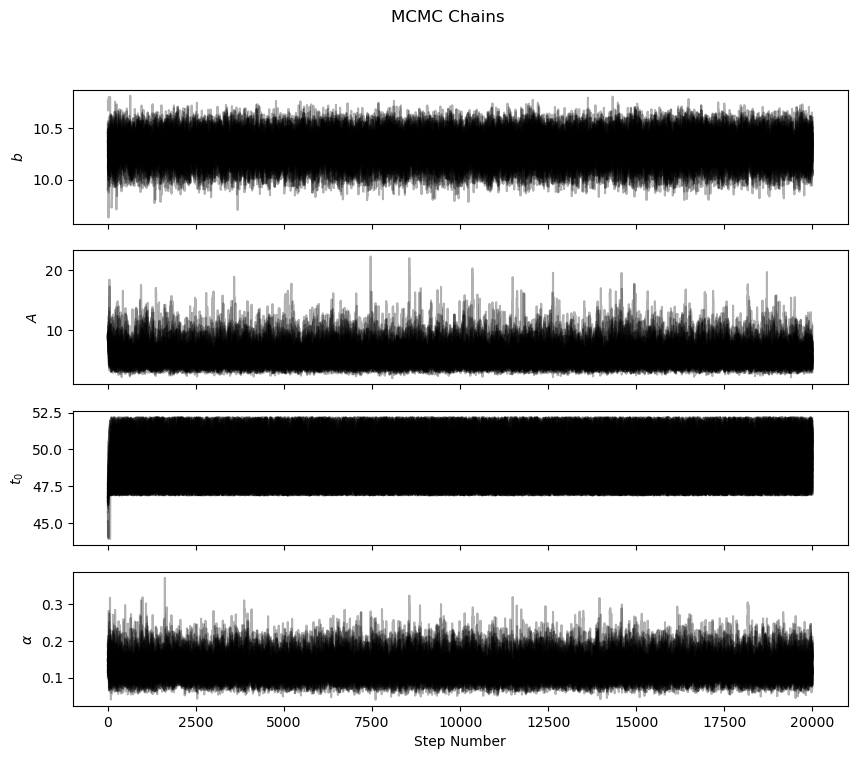

In [9]:
# Visualize parameter chains for diagnosing convergence
def plot_chains(sampler, labels):
    samples = sampler.get_chain()
    ndim = len(labels)
    
    fig, axes = plt.subplots(ndim, figsize=(10, 8), sharex=True)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], color='black', alpha=0.3)
        ax.set_ylabel(labels[i])
    axes[-1].set_xlabel("Step Number")
    plt.suptitle("MCMC Chains")
    plt.show()

plot_chains(sampler, labels)


In [10]:
# Burn-in and thinning with autocorrelation
def thin_with_autocorr(sampler, safety_factor_burn=3.0):
    tau = sampler.get_autocorr_time(quiet=True)
    max_tau = np.max(tau)
    burn = int(np.ceil(safety_factor_burn * max_tau))
    thin = int(np.ceil(max_tau))
    if thin < 1:
        thin = 1

    flat = sampler.get_chain(discard=burn, thin=thin, flat=True)
    return flat, tau, burn, thin

flat_samples, tau, burn, thin = thin_with_autocorr(sampler)
print("\n=== Autocorrelation diagnostics ===")
print(f"tau (per parameter) = {tau}")
print(f"Burn-in applied: {burn}  |  Thinning: every {thin} steps")
print(f"Final flattened chain shape: {flat_samples.shape}")


=== Autocorrelation diagnostics ===
tau (per parameter) = [56.89919624 72.21779595 73.17225157 58.63658884]
Burn-in applied: 220  |  Thinning: every 74 steps
Final flattened chain shape: (8544, 4)


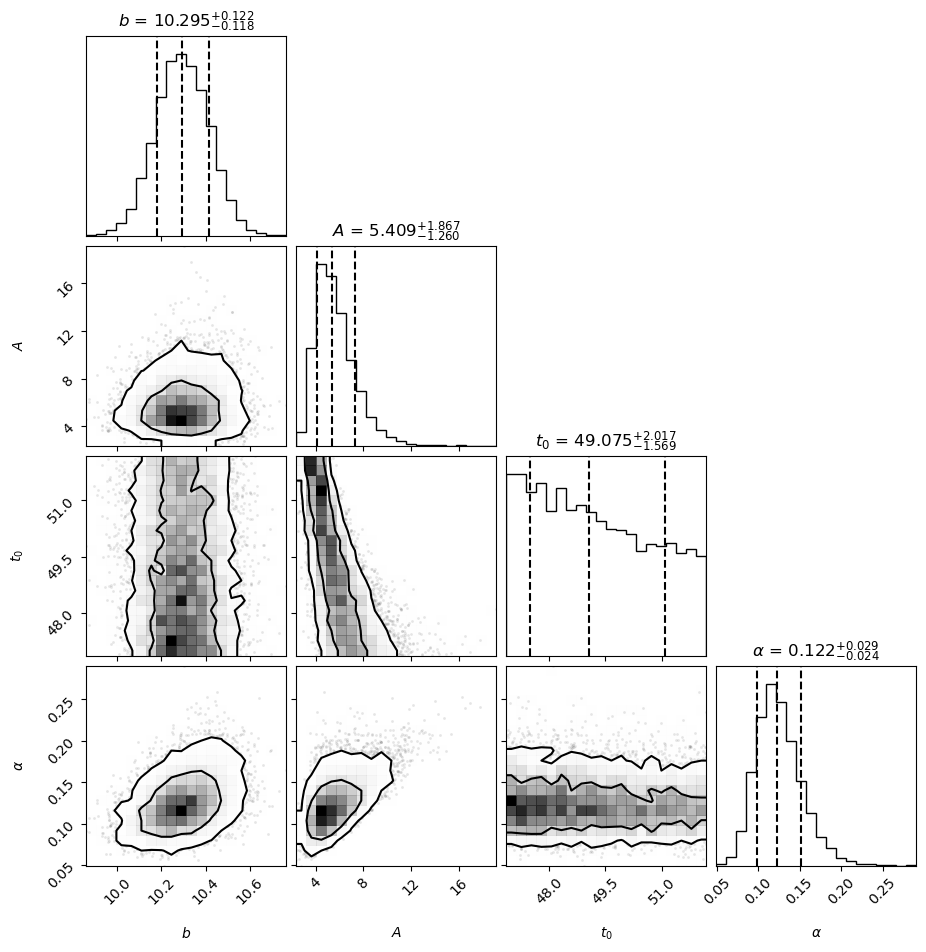

In [17]:

# Corner plot
fig = corner.corner(
    flat_samples,
    labels=labels,
    levels=(0.68, 0.95),
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    verbose=False
)


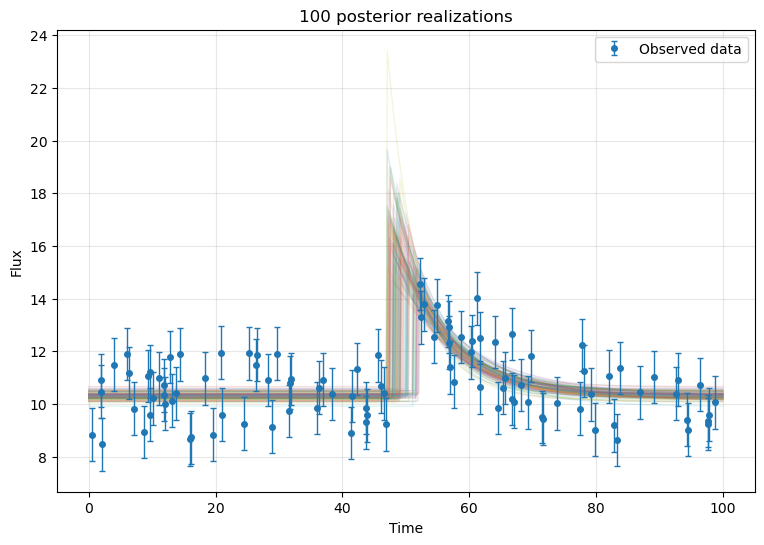

In [12]:

# 100 posterior realizations + data (posterior spread of model soultions)

def plot_posterior_realizations(samples, t, y, yerr, nsamples=100):
    t_fine = np.linspace(0, 100, 600)
    idx = rng.choice(len(samples), size=min(nsamples, len(samples)), replace=False)
    subset = samples[idx]

    fig, ax = plt.subplots(figsize=(9,6))
    for th in subset:
        ax.plot(t_fine, burst_model(th, t_fine), alpha=0.15, lw=1)

    plot_data(t, y, yerr, ax=ax)
    ax.set_title("100 posterior realizations")
    ax.legend()
    plt.show()

plot_posterior_realizations(flat_samples, t, y, yerr, nsamples=100)


In [13]:

# Parameter summary
def summarize_params(samples, labels):
    print("\nMarginal estimates (median and 90% credible interval):")
    summary = {}
    for i, lab in enumerate(labels):
        q5, q50, q95 = np.percentile(samples[:, i], [5, 50, 95])
        lo = q50 - q5
        hi = q95 - q50
        print(f"{lab}: {q50:.3f}  +{hi:.3f}  -{lo:.3f}  =>  {lab} = {q50:.3f}^{{+{hi:.3f}}}_{{-{lo:.3f}}}")

summarize_params(flat_samples, labels)


Marginal estimates (median and 90% credible interval):
$b$: 10.295  +0.198  -0.194  =>  $b$ = 10.295^{+0.198}_{-0.194}
$A$: 5.409  +3.491  -1.825  =>  $A$ = 5.409^{+3.491}_{-1.825}
$t_0$: 49.075  +2.770  -2.015  =>  $t_0$ = 49.075^{+2.770}_{-2.015}
$\alpha$: 0.122  +0.052  -0.036  =>  $\alpha$ = 0.122^{+0.052}_{-0.036}
